## Dataset

The dataset that was available to me consisted of 145 three dimensional MRI images of human knees. The contestens were all northern german males with ages ranging from 14 to 20. The data came from two different sources. 

- 80 512x512x24 images provided by Jopp et al.
- 65 800x800x41 images that were recorded specifically for this project

Out of these 145 images I was also provided with 76 segmentation maps of the three visible bones. The femur, tibia and fibula had different labels to differentiate between the bones.

## 1 Imports & Functions

In [50]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
from os.path import isfile
from tqdm import tqdm
import random
from glob import glob
import skimage.io as io
import skimage.transform as tr
from ipywidgets import FloatProgress
from IPython.display import display
import keras.backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras.preprocessing.image import *
import SimpleITK as sitk
from utils import *

In [51]:
def f1_score(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)

def f1_loss(y_true, y_pred):
    return -f1_score(y_true, y_pred)

In [52]:
def level_block(m, dim, depth, factor, acti, dropout):
    if depth > 0:
        n = Conv2D(dim, 3, activation=acti, padding='same')(m)
        n = Dropout(dropout)(n) if dropout else n
        n = Conv2D(dim, 3, activation=acti, padding='same')(n)
        m = MaxPooling2D()(n)
        m = level_block(m, int(factor*dim), depth-1, factor, acti, dropout)
        m = UpSampling2D()(m)
        m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        m = Concatenate(axis=3)([n, m])
    m = Conv2D(dim, 3, activation=acti, padding='same')(m)
    m = Dropout(dropout)(m) if dropout else m
    return Conv2D(dim, 3, activation=acti, padding='same')(m)

def UNet(img_shape, n_out=1, dim=64, depth=4, factor=2, acti='elu', dropout=None):
    i = Input(shape=img_shape)
    o = level_block(i, dim, depth, factor, acti, dropout)
    o = Conv2D(n_out, (1, 1))(o)
    o = Activation('sigmoid')(o)
    return Model(inputs=i, outputs=o)

In [53]:
from keras.models import Input, Model
from keras.layers import Conv2D, Concatenate, MaxPooling2D, Reshape
from keras.layers import UpSampling2D, Activation, Permute

def level_block_3d(m, dim, depth, factor, acti):
    if depth > 0:
        n = Conv3D(dim, 3, activation=acti, padding='same')(m)
        #n = Conv3D(dim, 3, activation=acti, padding='same')(n)
        m = MaxPooling3D((2,2,2))(n)
        m = level_block_3d(m, int(factor*dim), depth-1, factor, acti)
        m = UpSampling3D((2,2,2))(m)
        m = Conv3D(dim, 2, activation=acti, padding='same')(m)
        m = Concatenate(axis=4)([n, m])
    #m = Conv3D(dim, 3, activation=acti, padding='same')(m)
    return Conv3D(dim, 3, activation=acti, padding='same')(m)

def UNet_3D(img_shape, n_out=1, dim=8, depth=3, factor=1.5, acti='elu'):
    i = Input(shape=img_shape)
    o = level_block_3d(i, dim, depth, factor, acti)
    o = Conv3D(n_out, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)

In [ ]:
def

In [21]:
def n4_normalize(img):
    img = sitk.GetImageFromArray(img)
    img = sitk.Cast(img, sitk.sitkFloat32)
    mask = sitk.OtsuThreshold(img, 0, 1, 200)
    img = sitk.N4BiasFieldCorrection(img, mask)
    return sitk.GetArrayFromImage(img)

In [22]:
def load_data_seg(files, name='seg', size=None, crop=None):
    if isfile('data/x_' + name + '.npy'):
        print('Loading data from .npy files')
        x = np.load('data/x_' + name + '.npy')
        y = np.load('data/y_' + name + '.npy')
    else:
        print('Loading data from directory')
        files = glob(files)
        x, y = [], []
        for i in tqdm(range(len(files))):
            img = io.imread(files[i], plugin='simpleitk')
            if size and img.shape != size:   
                img = tr.resize(img, size, mode='constant')
            if crop:
                img = img[crop[0]:-1*crop[0], crop[1]:-1*crop[1], crop[2]:-1*crop[2]]
            img = (img-img.min()) / (img.max()-img.min())
            img[img < 0.0001] = 0
            img[img > 0.0001] = 1
            y.append(img)
            files[i] = files[i].replace('/LABEL/', '/MHD/', 1)
            files[i] = files[i].replace('_LABEL.', '_ORIG.', 1)
            img = io.imread(files[i], plugin='simpleitk')
            if size and img.shape != size:
                img = tr.resize(img, size, mode='constant')
            if crop:
                img = img[crop[0]:-1*crop[0], crop[1]:-1*crop[1], crop[2]:-1*crop[2]]
            img = (img-img.min()) / (img.max()-img.min())
            x.append(img)
        x = np.array(x)[..., np.newaxis].astype('float16')
        y = np.array(y)[..., np.newaxis].astype('int8')
        x, y = shuffle(x, y)
        np.save('data/x_' + name + '.npy', x)
        np.save('data/y_' + name + '.npy', y)
    return x, y

In [23]:
def load_data_ver(files, size=None, crop=None):
    files = glob(files)
    x = []
    for i in tqdm(range(len(files))):
        img = io.imread(files[i], plugin='simpleitk')
        if size and img.shape != size:
            img = tr.resize(img, size, mode='constant')
        if crop:
            img = img[crop[0]:-1*crop[0], crop[1]:-1*crop[1], crop[2]:-1*crop[2]]
        img = (img-img.min()) / (img.max()-img.min())
        x.append(img)
    x = np.array(x)[..., np.newaxis].astype('float16')
    return x

## 2 Preprocess Data

This will read, resize and normalize the images from Epi and Jopp. Afterwards they are stored in a compressed NPY file easy access from disk.

In [24]:
x, y = load_data_seg('data/*_Study/LABEL/*.mhd', name='seg_224', size=(36,368,368), crop=(6,72,72))
#x, y = load_data_seg('data/*_Study/LABEL/*.mhd', name='seg_192', size=(36,320,320), crop=(6,64,64))

Loading data from .npy files


In [25]:
x = to_2d(x)
y = to_2d(y)

In [26]:
print(x.shape, y.shape)

(1824, 224, 224, 1) (1824, 224, 224, 1)


In [27]:
train_size = 1584

x_tr = x[:train_size]
y_tr = y[:train_size]

x_te = x[train_size:]
y_te = y[train_size:]

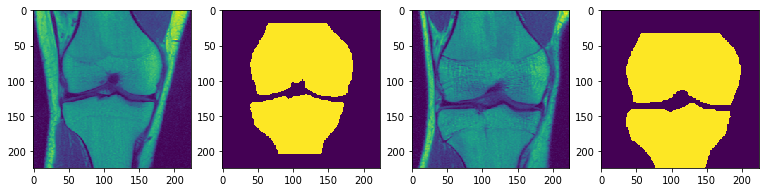

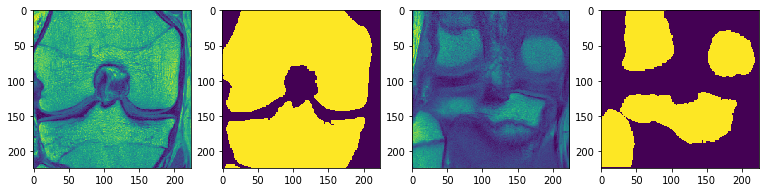

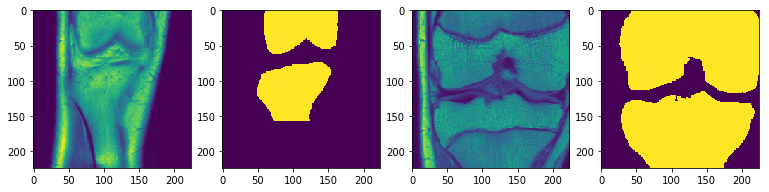

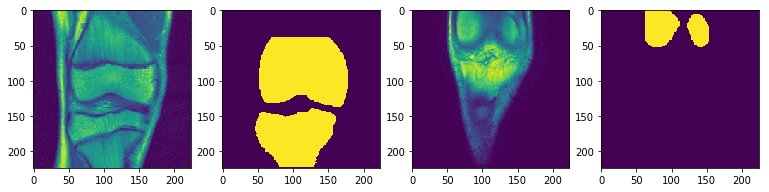

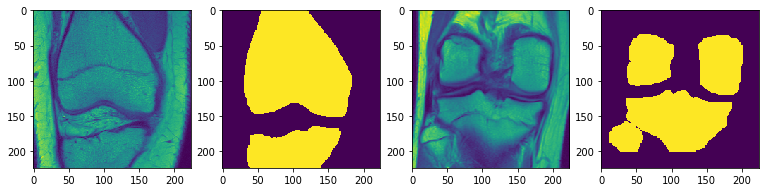

In [28]:
rndm = np.random.permutation(len(x_tr))

for i in range(0,10,2):
    plt.figure(figsize=(13, 4))
    plt.subplot(1,4,1)
    plt.imshow(x_tr[rndm[i], ..., 0].astype('float32'))
    plt.subplot(1,4,2)
    plt.imshow(y_tr[rndm[i], ..., 0].astype('float32'))
    plt.subplot(1,4,3)
    plt.imshow(x_tr[rndm[i+1], ..., 0].astype('float32'))
    plt.subplot(1,4,4)
    plt.imshow(y_tr[rndm[i+1], ..., 0].astype('float32'))
    plt.show()

## 5 Training

In [29]:
model = UNet((x_tr.shape[1:]), dim=32, depth=4, factor=1, dropout=0.2)
model.compile(optimizer=Adam(lr=0.0001), loss=f1_loss)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 224, 224, 32)      320       
_________________________________________________________________
dropout_19 (Dropout)         (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 112, 112, 32)      9248      
_________________________________________________________________
dropout_20 (Dropout)         (None, 112, 112, 32)      0         
__________

In [22]:
model = UNet((x_tr.shape[1:]), dim=16, depth=4, factor=1.5, dropout=0.2)
model.compile(optimizer=Adam(lr=0.0001), loss=f1_loss)
save_best = ModelCheckpoint('weights/seg2d_224_16_4_1.5_0.2.h5', 
                            save_best_only=True, 
                            save_weights_only=True)
stop_early = EarlyStopping(patience=7)
model.fit(x_tr, y_tr, validation_data=(x_te, y_te), epochs=60, batch_size=32, callbacks=[save_best, stop_early])

Train on 1584 samples, validate on 240 samples
Epoch 1/60
1584/1584 [==============================] - 34s - loss: -0.5660 - val_loss: -0.6182
Epoch 2/60
1584/1584 [==============================] - 31s - loss: -0.6926 - val_loss: -0.7073
Epoch 3/60
1584/1584 [==============================] - 31s - loss: -0.7809 - val_loss: -0.7050
Epoch 4/60
1584/1584 [==============================] - 30s - loss: -0.8039 - val_loss: -0.7313
Epoch 5/60
1584/1584 [==============================] - 30s - loss: -0.8170 - val_loss: -0.7619
Epoch 6/60
1584/1584 [==============================] - 30s - loss: -0.8278 - val_loss: -0.7700
Epoch 7/60
1584/1584 [==============================] - 30s - loss: -0.8368 - val_loss: -0.7880
Epoch 8/60
1584/1584 [==============================] - 30s - loss: -0.8511 - val_loss: -0.7928
Epoch 9/60
1584/1584 [==============================] - 30s - loss: -0.8595 - val_loss: -0.7927
Epoch 10/60
1584/1584 [==============================] - 30s - loss: -0.8666 - val_loss: 

In [25]:
model = UNet((x_tr.shape[1:]), dim=32, depth=4, factor=1, dropout=0.2)
model.compile(optimizer=Adam(lr=0.0001), loss=f1_loss)
save_best = ModelCheckpoint('weights/seg2d_224_32_4_1_0.2.h5', 
                            save_best_only=True, 
                            save_weights_only=True)
stop_early = EarlyStopping(patience=7)
model.fit(x_tr, y_tr, validation_data=(x_te, y_te), epochs=20, batch_size=32, callbacks=[save_best, stop_early])

Train on 1584 samples, validate on 240 samples
Epoch 1/20
1584/1584 [==============================] - 37s - loss: -0.9592 - val_loss: -0.9512
Epoch 2/20
1584/1584 [==============================] - 37s - loss: -0.9592 - val_loss: -0.9500
Epoch 3/20
1584/1584 [==============================] - 37s - loss: -0.9595 - val_loss: -0.9512
Epoch 4/20
1584/1584 [==============================] - 37s - loss: -0.9591 - val_loss: -0.9487
Epoch 5/20
1584/1584 [==============================] - 37s - loss: -0.9598 - val_loss: -0.9523
Epoch 6/20
1584/1584 [==============================] - 37s - loss: -0.9603 - val_loss: -0.9512
Epoch 7/20
1584/1584 [==============================] - 37s - loss: -0.9602 - val_loss: -0.9516
Epoch 8/20
1584/1584 [==============================] - 37s - loss: -0.9606 - val_loss: -0.9507
Epoch 9/20
1584/1584 [==============================] - 37s - loss: -0.9608 - val_loss: -0.9503
Epoch 10/20
1584/1584 [==============================] - 37s - loss: -0.9610 - val_loss: 

For the segmentation I built on two U-Net like architectures. Both were very small variants of the original U-Net because I had so little data to train on. Using the original with its millions of parameters I would have started to overfit very early. Both models had a depth of 4 and Dropout of 0.2 in the encoding and decoding parts. Network A had 16 input channels that were multiplied by 1.5 for every layer down. Network B had 32 channels all the way down the network. This was inspired by a Kaggle competition solution from deepense.io who noticed no improvement when increasing the number of channels down the network. Network A had 340k parameters opposed to the 210k in Network B. The training time for 1 epoch was 

    - Network A: 16 channels, growth rate 1.5, 340k parameters, 27s per epoch
    - Network B: 32 channels, growth rate 1.0, 210k parameters, 37s per epoch
    
As we can see here the number of parameters has no linear effect on the time per epoch. Most of the time it'S the first layer that puts a bottleneck on all following layers. After 85 epochs Network B reached a validation accuracy of 95,23% IoU and stopped improving from here on. With 95,98% on the training set it also overfitted just a little. Network A was stopped after 60 epochs were the training validation was similar (95,66%) to Network B. However, the validation score was 92,99% indicating that it already overfitted quite a bit. This shows that the higher number of parameters have a negative effect when it comes to overfitting. It also shows that deeper layers don't benefit from increasing channel sizes.

In [21]:
score = model.evaluate(x_te, y_te)
msg = 'Test Set MAE: ' + str(score)
pushover('Training finished', msg)

RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

## 5 Verification

In [30]:
model.load_weights('weights/seg2d_9523_224_32_4_1_0.2.h5')

In [29]:
x_te_pred = model.predict(x_te, batch_size=16, verbose=1)
x_te_masked = x_te * x_te_pred

240/240 [==============================] - 1s     


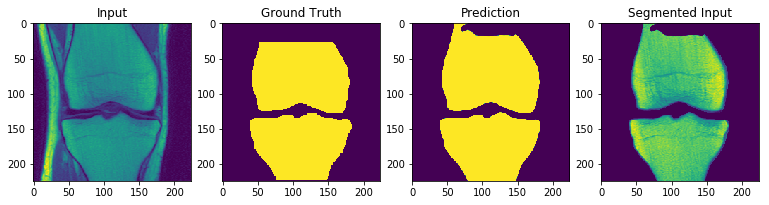

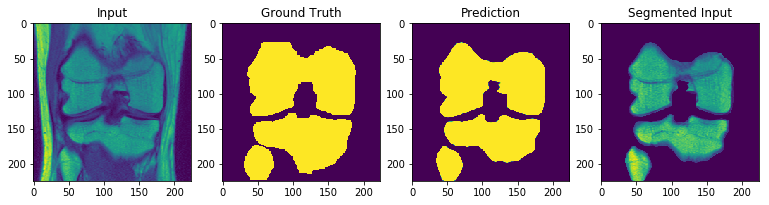

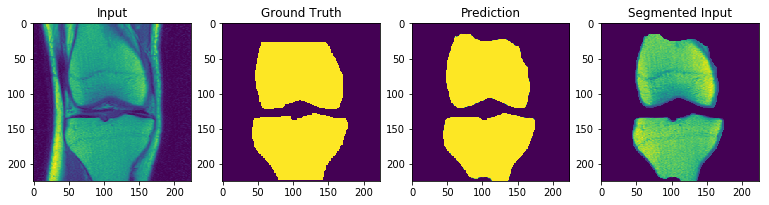

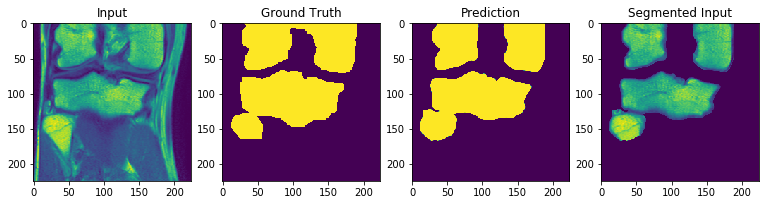

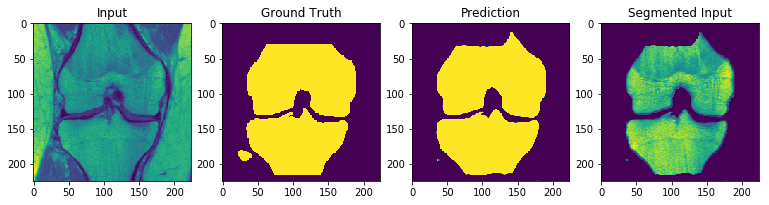

In [32]:
rndm = np.random.permutation(len(x_te))
for i in range(0,5):
    plt.figure(figsize=(13, 5))
    plt.subplot(1,4,1)
    plt.title('Input')
    plt.imshow(x_te[rndm[i], ..., 0].astype('float32'))
    plt.subplot(1,4,2)
    plt.title('Ground Truth')
    plt.imshow(y_te[rndm[i], ..., 0].astype('float32'))
    plt.subplot(1,4,3)
    plt.title('Prediction')
    plt.imshow(x_te_pred[rndm[i], ..., 0].astype('float32'))
    plt.subplot(1,4,4)
    plt.title('Segmented Input')
    plt.imshow(x_te_masked[rndm[i], ..., 0].astype('float32'))
    plt.show()


In [34]:
x_ver = load_data_ver('data/Maas_Study/MHD/*.mhd', size=(36,368,368), crop=(6,72,72))

100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


In [36]:
x_ver = to_2d(x_ver)

In [37]:
x_pred = model.predict(x_ver)

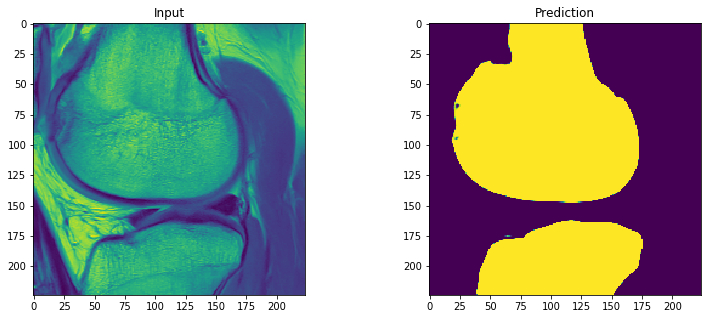

In [49]:
i = 100
plt.figure(figsize=(13, 5))
plt.subplot(1,2,1)
plt.title('Input')
plt.imshow(x_ver[i, ..., 0].astype('float32'))
plt.subplot(1,2,2)
plt.title('Prediction')
plt.imshow(x_pred[i, ..., 0].astype('float32'))